In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.utils import shuffle
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
!pip install transformers

import torch
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer
from torch.utils.data import Dataset
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertForSequenceClassification
from IPython.display import display, clear_output
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm


In [ ]:
true_path = '/content/drive/MyDrive/27389/True.csv'
fake_path = '/content/drive/MyDrive/27389/Fake.csv'
true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

In [ ]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


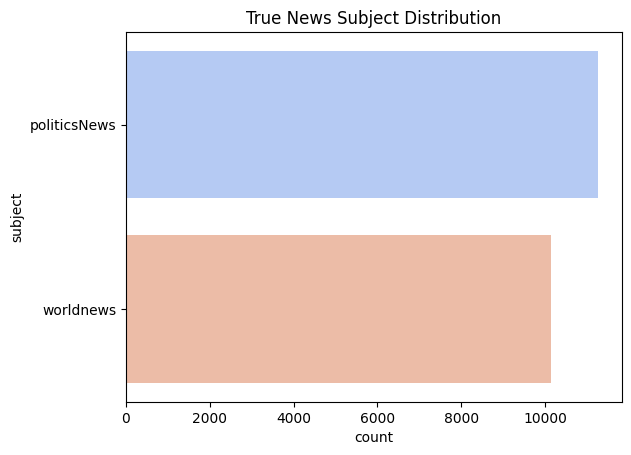

In [ ]:
sns.countplot(y="subject", palette="coolwarm", data=true_df).set_title('True News Subject Distribution')
plt.show()


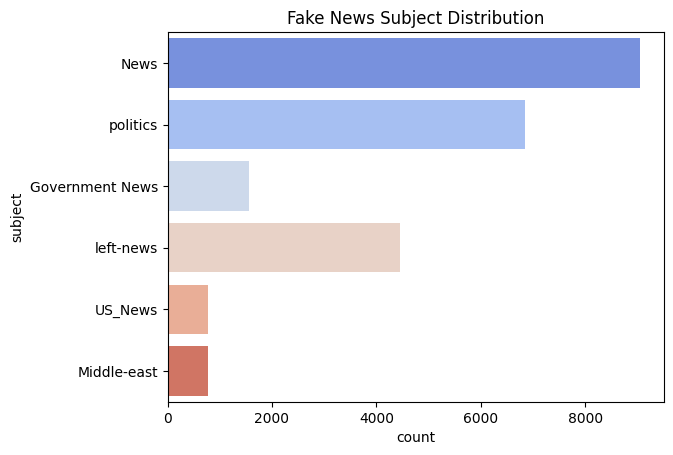

In [ ]:
sns.countplot(y="subject", palette="coolwarm", data=fake_df).set_title('Fake News Subject Distribution')
plt.show()

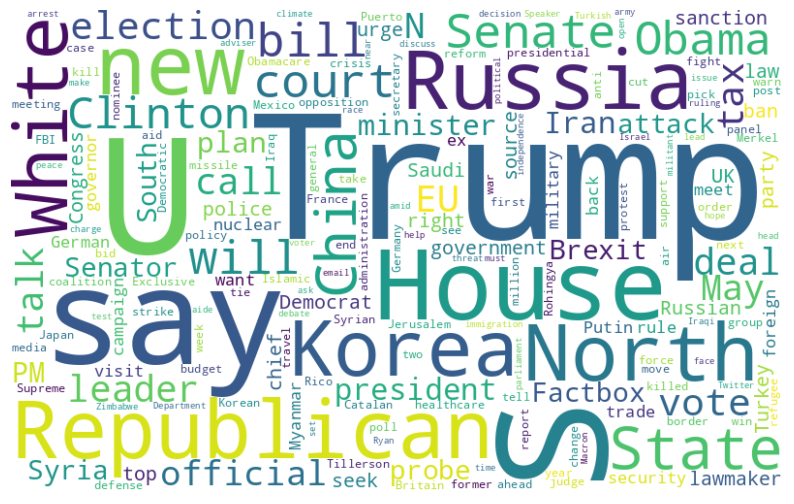

In [ ]:
real_titles = true_df.title
real_titles_ls = [text for text in real_titles]
# print(alls)
real_all_words = ' '.join(real_titles)
wordcloud_real = WordCloud(background_color='white',
    width= 800, height= 500,
    max_font_size = 180,
    collocations = False).generate(real_all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.show()

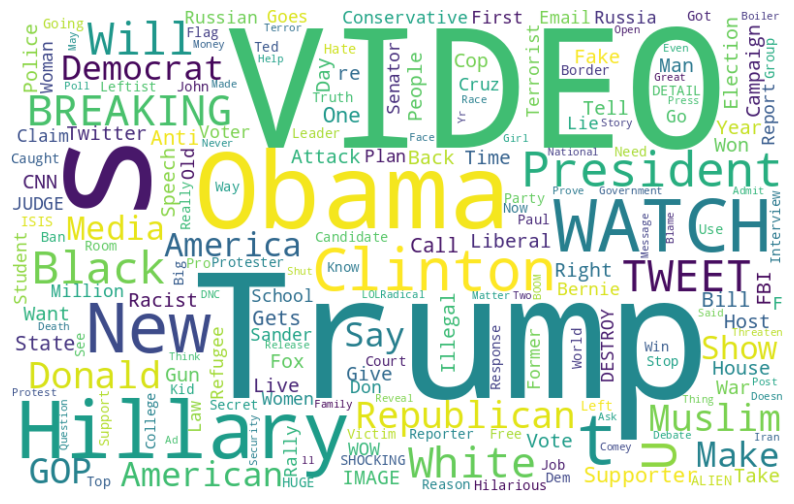

In [ ]:
fake_titles = fake_df.title
fake_titles_ls = [text for text in fake_titles]
# print(alls)
fake_all_words = ' '.join(fake_titles)
wordcloud_fake = WordCloud(background_color='white',
    width= 800, height= 500,
    max_font_size = 180,
    collocations = False).generate(fake_all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
true_df['true'] = 1
fake_df['true'] = 0
df = pd.concat([true_df, fake_df])

In [ ]:
df.head()

,title,text,subject,date,true
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
titles = [text for text in df.title]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))

Number of titles: 44898
Max length of the titles: 42
Mean length of the titles: 12.453472315025168


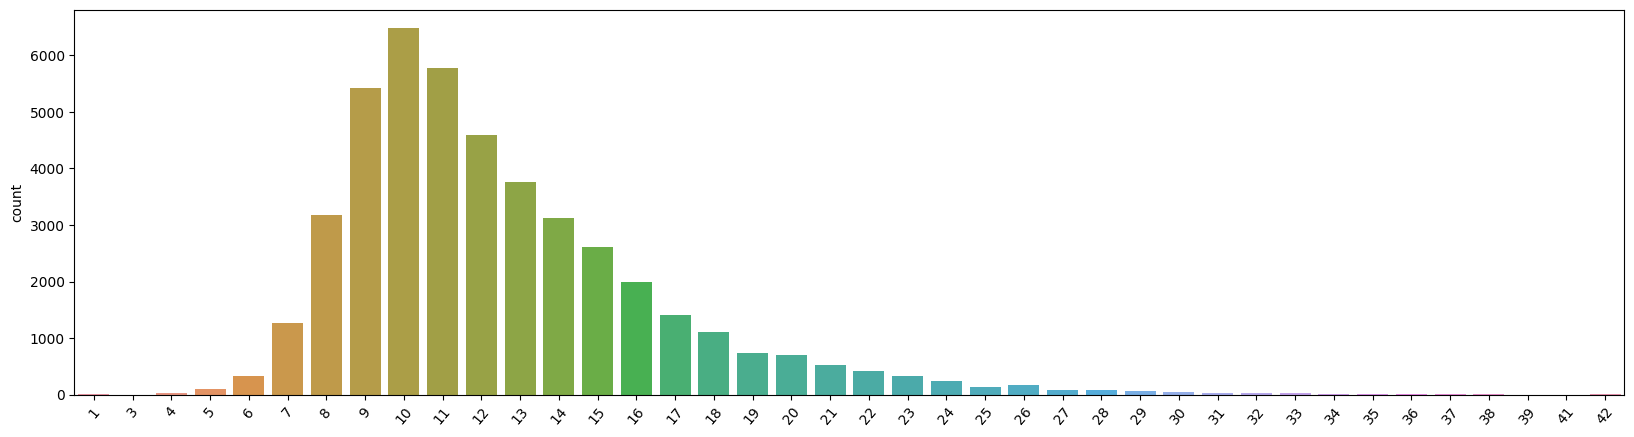

In [ ]:
plt.figure(figsize=(20,5))
g = sns.countplot(x=titles_len)
g.set_xticklabels(g.get_xticklabels(), rotation=50)
plt.show()

In [ ]:
texts = [text for text in df.text]

max_len = 0
texts_len = []
for text in texts:
    texts_len.append(len(text.split()))
    max_len = max(len(text.split()), max_len)

# g = sns.countplot(x=texts_len)
print('Mean length of the texts:', np.mean(texts_len))

Mean length of the texts: 405.28228428883244


In [ ]:

# Purify
df = df.iloc[:,[0, -1]]

# Shuffle
df = shuffle(df).reset_index(drop=True)

In [ ]:
df.head()

,title,true
0,THAT’S GONNA LEAVE A MARK…Anti-Trump Punks Att...,0
1,Over $500 million in Thai bank shares transfer...,1
2,WATCH: SNL BRUTALLY Mocks The Kushner/Bannon ...,0
3,BREAKING: 5 People Shot At Anti-Trump Protest…...,0
4,"Without Trump, Republican debate has second lo...",1


In [ ]:
df.shape

(44898, 2)

In [ ]:
train_df = df.sample(frac = 0.8)
test_df = df.drop(train_df.index)
# Reset Index
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print('trainset size:', train_df.shape)
print('testset size:', test_df.shape)

trainset size: (35918, 2)
testset size: (8980, 2)


In [ ]:
train_df.to_csv('train.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

In [ ]:
df1 = pd.concat([train_df, test_df])
df1.head()

,title,true
0,WATCH: Trump Supporter Gets His A** Handed To...,0
1,French unions block fuel depots in protest aga...,1
2,A divided Republican party: Donald or Ivanka f...,1
3,Cameroon court sentences opposition leader to ...,1
4,LAVAR BALL: Here’s Why President Trump Was Und...,0


In [ ]:

# Downloading Stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Obtaining Additional Stopwords From nltk

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
    return result

In [ ]:
df['clean'] = df['title'].apply(preprocess)

In [ ]:
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

total_words = len(list(set(list_of_words)))
print('total words in the dataset', total_words)

total words in the dataset 19174


In [ ]:
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(train_df['title'])
train_sequences = tokenizer.texts_to_sequences(train_df['title'])
test_sequences = tokenizer.texts_to_sequences(test_df['title'])

In [ ]:
padded_train = pad_sequences(train_sequences,maxlen = 42, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 42, padding = 'post', truncating = 'post')

In [ ]:
## Creating model Using LSTM
embedding_vector_features=40
model=Sequential()
model.add(Embedding(total_words,embedding_vector_features,input_length=42))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 42, 40)            766960    
                                                                 
 dropout_2 (Dropout)         (None, 42, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 823,461
Trainable params: 823,461
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
y_train = np.asarray(train_df['true'])
y_test = np.asarray(test_df['true'])
model.fit(padded_train, y_train, batch_size = 64, validation_data=(padded_test, y_test), epochs = 3)

Epoch 1/3
562/562 [==============================] - 59s 99ms/step - loss: 0.2133 - accuracy: 0.8934 - val_loss: 0.0980 - val_accuracy: 0.9650
Epoch 2/3
562/562 [==============================] - 65s 116ms/step - loss: 0.0545 - accuracy: 0.9820 - val_loss: 0.0910 - val_accuracy: 0.9702
Epoch 3/3
562/562 [==============================] - 70s 125ms/step - loss: 0.0311 - accuracy: 0.9897 - val_loss: 0.0895 - val_accuracy: 0.9713


In [ ]:
prediction = model.predict(padded_test)
y_test = np.asarray(test_df['true'])
prediction = np.where(prediction> 0.5,1,0)
accuracy = accuracy_score(list(y_test), prediction)
print("LSTM Model Accuracy : ", accuracy)

281/281 [==============================] - 7s 23ms/step
LSTM Model Accuracy :  0.9712694877505568


<Axes: >

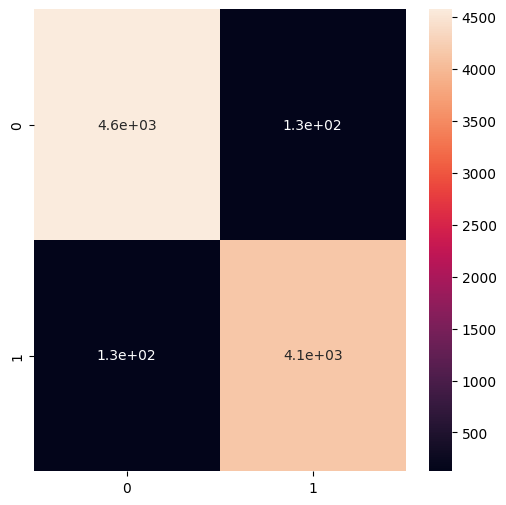

In [ ]:
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot = True)

In [ ]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4701
           1       0.97      0.97      0.97      4279

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



# BERT

In [ ]:
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [ ]:
class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train','test']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer
    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        return (tokens_tensor, segments_tensor, label_tensor)
    def __len__(self):
        return self.len

In [ ]:
trainset = FakeNewsDataset('train', tokenizer=tokenizer)
testset = FakeNewsDataset('test', tokenizer=tokenizer)
print('trainset size:' ,trainset.__len__())
print('testset size: ',testset.__len__())

trainset size: 35918
testset size:  8980


In [ ]:
sample_idx = 0
statement, label = trainset.df.iloc[sample_idx].values
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)
print(f"""
original_statement: 
{statement}

tokens: 
{tokens}

label: {label}

--------------------

tokens_tensor: 
{tokens_tensor}

segments_tensor: 
{segments_tensor}

label_tensor: 
{label_tensor}

""")


original_statement: 
Zimbabwe's Mnangagwa adds to calls for Mugabe to go

tokens: 
['[CLS]', 'zimbabwe', "'", 's', 'mn', '##anga', '##g', '##wa', 'adds', 'to', 'calls', 'for', 'mug', '##abe', 'to', 'go', '[SEP]']

label: 1

--------------------

tokens_tensor: 
tensor([  101, 11399,  1005,  1055, 24098, 18222,  2290,  4213,  9909,  2000,
         4455,  2005, 14757, 16336,  2000,  2175,   102])

segments_tensor: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

label_tensor: 
1




In [ ]:
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids
BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [ ]:
data = next(iter(trainloader))
tokens_tensors, segments_tensors, masks_tensors, label_ids = data

In [ ]:
PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2
model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)
clear_output()
print("""
name             module
-----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:16} {}".format(name, module))


name             module
-----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout          Dropout(p=0.1, inplace=False)
classifier       Linear(in_features=768, out_features=2, bias=True)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 3
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0
    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
        optimizer.zero_grad()
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())
        train_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

device: cpu


  0%|          | 0/562 [00:00<?, ?it/s]